# Mushroom Prediction: A Preliminary Notebook

<div style="border: 2px double #dcdcdc; padding: 10px; border-radius: 5px; background-color: #202020; max-width: 97.5%; overflow-x: auto;">
<h2> Version Log </h2>
<p>
<br>[4_8_2024]: Debugged the models and their parameters. Enhanced the code for better migration to kaggle
<br>[3_8_2024]: Completed data preprocessing. Constructed and trained various base-lv models and ensembled into a meta-model. 
                Made prediction, MCC = 0.98
<br>[2_8_2024]: Completed data cleaning 
</p>
</div>

## 1. Setup Environment:

In [28]:
## This is a Juptyer notebook for the Kaggle Project: Mushroom Classification
# %pip install ydata-profiling
# %pip install numpy
# %pip install --upgrade pandas
# %pip install --upgrade matplotlib
# %pip install --upgrade seaborn
# %pip install --upgrade scikit-learn
# %pip install --upgrade scipy
# %pip install --upgrade catboost
# %pip install --upgrade xgboost
# %pip install --upgrade lightgbm
# %pip install ipywidgets

In [29]:
## Import libaries
import os

## Data analysis and wrangling
import numpy as np
import pandas as pd
import random as rnd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from ydata_profiling import ProfileReport
%matplotlib inline 
from scipy.stats import boxcox

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef


# Machine learning_ Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

# # Model selection
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


#Palette
palette = ['#328ca9', '#0e6ea9', '#2c4ea3', '#193882', '#102446']

# Set the style of the visualization
sns.set(style="whitegrid")

# Set the configuration of sklearn
SEED = 42 # for reproducibility

## 2.  Problem identification

### Problem Statement:

This is one of the 2024 playground competitions on Kaggle. 

The major goal of the project is to develope a classifier for classifying muchrooms into edible or poisonous based on physical characteristics presented in tabulated formats. 
The performance of the model will be assessed by the Matthews correlation coefficient (MCC), that is calculated by:

$$MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$$


<br> Reference:
<br> [1] Walter Reade, Ashley Chow. (2024). Binary Prediction of Poisonous Mushrooms. Kaggle. https://kaggle.com/competitions/playground-series-s4e8
<br> [2] https://archive.ics.uci.edu/dataset/73/mushroom 

## 3. Reading Data

In [30]:
## Reading data

# Check if running on Kaggle
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    train_df=pd.read_csv(r'/kaggle/input/playground-series-s4e8/train.csv')#
    test_df=pd.read_csv(r'/kaggle/input/playground-series-s4e8/train.csv')#
else:
    train_df=pd.read_csv(r'Input\train.csv')#
    test_df=pd.read_csv(r'Input\test.csv')

## 4. Data Inspection

### 4.1. The number of features

In [31]:
# Number of columns and rows in the dataset
print(train_df.columns.values)
print(train_df.shape)

['id' 'class' 'cap-diameter' 'cap-shape' 'cap-surface' 'cap-color'
 'does-bruise-or-bleed' 'gill-attachment' 'gill-spacing' 'gill-color'
 'stem-height' 'stem-width' 'stem-root' 'stem-surface' 'stem-color'
 'veil-type' 'veil-color' 'has-ring' 'ring-type' 'spore-print-color'
 'habitat' 'season']
(3116945, 22)


<div style="border: 2px solid #000000; padding: 10px; border-radius: 5px; background-color: #282828; max-width: 97.5%; overflow-x: auto;">
<p>
<br> There are 22 features in the 3116945 entries in the training dataset. 
<br> The id is the index of the data entry; the class is the target variable and the others are features.  
<br> The cap, bruise, gill, stem, veil and ring are different parts of a mushroom that can be found in the anatomy shown below. </p>
</div>

From https://archive.ics.uci.edu/dataset/73/mushroom, the features included are:
1. id                   = the index of the data entry
2. class                = e (edible)/ p (poisonous) - <b>The target variable </b>
3. cap-diameter         = The di
4. cap-shape            = a shape descriptor of the mushroom's cap 
5. cap-surface          = a surface descriptor 
6. cap-color            = the color of the mushroom cap
7. does-bruise-or-bleed = Will the mushroom change color when being bruised or cut 
8. gill-attachment      = Does the mushroom have gill attached
9. gill-spacing         = the spacing of gill under the cap of mushroom  
10. gill-color          = the color of the gill
11. stem-height         = 
12. stem-width          = 
13. stem-root           = 
14. stem-surface        = 
15. stem-color          = the color of the stem
16. veil-type           = the type of the veil 
17. veil-color          = the color of the veil
18. has-ring            = the existance of rings
19. ring-type           = the type of rings.
20. spore-print-color   = the color of print of spore obtained by cutting the cap and gill and cover with a blank paper.
21. habitat             = the habit of the mushrooms.
22. season              = the season of obtaining the mushrooms.



![alt text](<Anatomy of a Mushroom Graphic-1.webp>)

In [32]:
# Look at the first 5 rows of the dataset
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [33]:
# Look at the last 5 rows of the dataset
train_df.tail()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
3116940,3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,3116941,e,10.88,s,NaN,w,t,d,c,p,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,3116942,p,7.82,x,e,e,f,a,NaN,w,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
3116943,3116943,e,9.45,p,i,n,t,e,NaN,p,...,NaN,y,w,NaN,NaN,t,p,NaN,d,u
3116944,3116944,p,3.20,x,s,g,f,d,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,u


### 4.2. Data type of the variables

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

<div style="border: 2px solid #000000; padding: 10px; border-radius: 5px; background-color: #282828; max-width: 97.5%; overflow-x: auto;">
<p>
<br> It is observed that most of the variables are categoiral, except id, cap-diameter , stem-height and stem-width, which are numerical.  </p>
</div>


In [35]:
# Display the unique values and the count of unique values in the dataset
train_df.describe(include=['O'])


,class,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
count,3116945,3116905,2445922,3116933,3116937,2593009,1858510,3116888,359922,1136084,3116907,159452,375998,3116921,2988065,267263,3116900,3116945
unique,2,74,83,78,26,78,48,63,38,60,59,22,24,23,40,32,52,4
top,p,x,t,n,f,a,c,w,b,s,w,u,w,f,f,k,d,a
freq,1705396,1436026,460777,1359542,2569743,646034,1331054,931538,165801,327610,1196637,159373,279070,2368820,2477170,107310,2177573,1543321


### 4.3 Handling missing, distinct and duplicated entries:

#### 4.3.1 Number of Missing/ distinct and duplicated entries:

In [36]:
print("Missing Data in the training dataset (%)")
print("="*40)
print((train_df.isnull().sum()/len(train_df)*100).sort_values(ascending = False).round(3))
print("="*40)

Missing Data in the training dataset (%)
veil-type               94.884
spore-print-color       91.425
stem-root               88.453
veil-color              87.937
stem-surface            63.551
gill-spacing            40.374
cap-surface             21.528
gill-attachment         16.809
ring-type                4.135
gill-color               0.002
habitat                  0.001
cap-shape                0.001
stem-color               0.001
has-ring                 0.001
cap-color                0.000
does-bruise-or-bleed     0.000
cap-diameter             0.000
id                       0.000
stem-width               0.000
class                    0.000
stem-height              0.000
season                   0.000
dtype: float64


In [37]:
print("Distinct Data in the training dataset (%)")
print("="*40)
print(train_df.nunique().sort_values(ascending = False))
print("="*40)

Distinct Data in the training dataset (%)
id                      3116945
stem-width                 5836
cap-diameter               3913
stem-height                2749
cap-surface                  83
cap-color                    78
gill-attachment              78
cap-shape                    74
gill-color                   63
stem-surface                 60
stem-color                   59
habitat                      52
gill-spacing                 48
ring-type                    40
stem-root                    38
spore-print-color            32
does-bruise-or-bleed         26
veil-color                   24
has-ring                     23
veil-type                    22
season                        4
class                         2
dtype: int64


In [38]:
print("Duplicated Data in the training dataset (%)")
print("="*40)
print((train_df.duplicated().sum()/len(train_df)*100).round(3))
print("="*40)

Duplicated Data in the training dataset (%)
0.0


<div style="border: 2px solid #000000; padding: 10px; border-radius: 5px; background-color: #282828; max-width: 97.5%; overflow-x: auto;">
<p>
<br>  There are multiple missing values in the data with some of them contribute a large portion of the entries (e.g. veil-type & spore-print-color). </p>
</div>



b. Understand the cause and type of missing data. 

Different types of missing data may leads to different handling methods. Following are some examples of missing data and their handling methods.

Missing Completely at Random (MCAR):

Handling method: Simple imputation
Cause: The probability of missing an entry is completely independent of the values of the variables in the dataset, as well as the unobserved data.
Example: a sensor malfunctions and randomly fails to record some measurements
Missing at Random (MAR):

Handling method: advanced imputation techniques
Cause: The probability of a data point being missing depends on the observed variables in the dataset, but not on the unobserved (missing) data.
Example: income data is more likely to be missing for individuals with lower education levels
Missing Not at Random (MNAR):

Handling methods: pattern mixture models or selection models
Causes: the probability of a data point being missing depends on the unobserved (missing) data itself.
Example: individuals with higher income are less likely to report their income
Systematic Missing Data:

Handling methods: Simple imputation or creating Proxy variable
Causes: An entire variables or features are missing from the dataset, typically due to issues in data collection or data processing.
Example: A sensor was not installed on certain devices, resulting in the absence of data for a specific feature

> Right now, we will choose to impute the missing values by the most frequent option in the categorical features. And for distint values, we will keep only the most frequent 5 options in each feature to reduce the cardinality. 

c. Handling of the missing/distinct/diplicated data.



In [39]:
# Drop features that have > 50% missing values
train_df = train_df.dropna(thresh=0.5*len(train_df), axis=1)
# Drop the 'target' column and assign it to the target variable
y = train_df['class']
train_df = train_df.drop(['class'], axis=1)
# Drop the same features in the test dataset
test_df = test_df[train_df.columns]


In [40]:
# imputate missing values
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        # print(f"Imputing {col} with mode")
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)

for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        # print(f"Imputing {col} with mode")
        test_df[col].fillna(test_df[col].mode()[0], inplace=True)
# Check if there are any missing values
print("Missing Data in the training dataset (%)")
print("="*40)
print((train_df.isnull().sum()/len(train_df)*100).sort_values(ascending = False).round(3))
print("="*40)


C:\Users\Kai Qi Yan\AppData\Local\Temp\ipykernel_19116\4072610812.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].mode()[0], inplace=True)
C:\Users\Kai Qi Yan\AppData\Local\Temp\ipykernel_19116\4072610812.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Missing Data in the training dataset (%)
id                      0.0
cap-diameter            0.0
cap-shape               0.0
cap-surface             0.0
cap-color               0.0
does-bruise-or-bleed    0.0
gill-attachment         0.0
gill-spacing            0.0
gill-color              0.0
stem-height             0.0
stem-width              0.0
stem-color              0.0
has-ring                0.0
ring-type               0.0
habitat                 0.0
season                  0.0
dtype: float64


Next we are going to keep only the 5 most frequent values in the categorial columns, others will be categorized as others. 

In [41]:
# Drop the 'Id' colum since it's unnecessary for the prediction process
train_df = train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)

# separate the numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=[object]).columns.tolist()
# Keep only the 5 most frequent values in the categorical columns
for col in categorical_cols:
    top_5 = train_df[col].value_counts().head(5).index
    train_df.loc[~train_df[col].isin(top_5), col] = 'Other'
    test_df.loc[~test_df[col].isin(top_5), col] = 'Other'

train_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,8.80,f,s,Other,f,a,c,w,4.51,15.39,w,f,f,d,a
1,4.51,x,h,Other,f,a,c,n,4.79,6.48,o,t,z,d,w
2,6.94,f,s,Other,f,x,c,w,6.85,9.93,n,f,f,l,w
3,3.88,f,y,g,f,s,c,g,4.16,6.53,w,f,f,d,u
4,5.85,x,Other,w,f,d,c,w,3.37,8.36,w,f,f,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,9.29,f,t,n,t,a,c,w,12.14,18.81,w,t,Other,d,u
3116941,10.88,s,t,w,t,d,c,p,6.65,26.97,w,f,f,d,u
3116942,7.82,x,Other,e,f,a,c,w,9.51,11.06,y,t,z,d,a
3116943,9.45,Other,Other,n,t,e,c,p,9.13,17.77,w,t,Other,d,u


4.4. Summary of the dataset by ProfileReport

In [42]:
# profile=ProfileReport(train_df,title='Pandas Profiling Report',explorative=True)
# profile.to_notebook_iframe()

## 5. Feature Preprocessing

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# visualizing pipeline
set_config(display='diagram')

# Define a function to preprocess the data
def PreprocessData(df):
    '''
    This function preprocesses the data by imputing missing values and scaling the numerical features.
    '''

    # Define the numerical and categorical features
    num_features = df._get_numeric_data().columns
    cat_features = list(set(df.columns) - set(num_features))

    # Set up the numerical and categorical transformers
    numeric_transformer = Pipeline(
    steps=[("imputation_mean",SimpleImputer(missing_values=np.nan,strategy="mean")),
          ("scaler",StandardScaler())]
    )
    categorial_transformer = Pipeline(
    steps=[("imputation_mode",SimpleImputer(missing_values=np.nan,strategy="most_frequent")),('onehot',OneHotEncoder(handle_unknown='ignore'))]
    )
    # Set up the preprocessor
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorial_transformer, cat_features)
    ])

    # Fit and transform the data
    X = preprocessor.fit_transform(df)

    # Return the preprocessed data
    return X, preprocessor

In [44]:
# Preprocess the data
X, preprocessor = PreprocessData(train_df)
X1, preprocessor = PreprocessData(test_df)
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

## 6. 1st Level models

### 6.1. Model list

In [45]:
# create a utility function to sort the dictionary by values aphabatically
def sort_dict(d):
    return dict(sorted(d.items(), key=lambda x: x[0]))

# Define a list of models for prediction
classifiers = {
    # "Logistic Regression": LogisticRegression(),
    # "Random Forest Classifier": RandomForestClassifier(),
    # "Gradient Boosting Classifier": GradientBoostingClassifier(),
    # "Support Vector Classifier": SVC(),
    # "XGBClassifier": XGBClassifier(),
#     "MLP Classifier": MLPClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=1), algorithm='SAMME'),
    # "Dummy Classifier": DummyClassifier(strategy='most_frequent')  # DummyClassifier for sanity check
}

# Sort the models
classifiers=sort_dict(classifiers)

### 6.2 Model parameters

In [46]:
# Define the parameters for the hyperparamter tuning of models by RandomizedSearchCV
import scipy.stats as stats

params_classifiers = {

    # "Logistic Regression": {
    #     'solver': ['newton-cg', 'sag', 'lbfgs'],  
    #     'penalty': ['l2', None],  
    #     'C': [0.1],
    #     'max_iter': [100, 200, 300]
    # },

    # "Random Forest Classifier": {
    #     'n_estimators': [64, 128, 256],
    #     'criterion': ['entropy'],
    #     'warm_start': [True]

    # },

    # "Gradient Boosting Classifier": {
    #     'learning_rate': stats.loguniform(1e-2, 1e-1),
    #     'n_estimators': [8, 16, 32, 64, 128, 256],
    #     'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
    # },

    # "Support Vector Classifier": {
    #     'C': stats.loguniform(1e-2, 1e2),
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     'gamma': ['scale', 'auto']
    # },

    # "XGBClassifier": {
    #         'objective':['binary:logistic'],
    #         'max_depth': [3, 5, 7, 9],
    #         'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    #         'n_estimators': [16, 32, 64, 128, 256]
    #     },


#     "MLP Classifier": {
#         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
#         'activation': ['tanh', 'relu'],
#         'solver': ['sgd', 'adam'],
#         'alpha': stats.loguniform(1e-5, 1e-2),
#         'learning_rate': ['constant', 'adaptive']
#     },
    
    "Extra Trees Classifier": {
        'n_estimators': [128, 256,524],
        'criterion': ['entropy'],
        'max_features': [10, 20, 40],
        'min_samples_split': [2, 5, 10],
        # 'warm_start': [True]
    },

    "AdaBoost Classifier": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': stats.loguniform(1e-4, 1e-1),
    },

    # "Dummy Classifier": {}
}

# Sort the parameters
params_classifiers = sort_dict(params_classifiers)

6.3. Model training and hyperparameters tuning

a. Setup scoring method for the model optimization

In [47]:
from sklearn.model_selection import StratifiedKFold

# Setup the KFold
NFOLDS = 3 # set folds for out-of-fold prediction
kf = StratifiedKFold(n_splits= NFOLDS,shuffle=True, random_state=SEED)

In [48]:
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef

# Define a custom cost function for the RandomizedSearchCV
def MCC(y_true, y_pred):
    MCC= matthews_corrcoef(y_true, y_pred)
    return MCC

In [49]:
# Define a function to obtain the out of fold predictions
def get_oof_predictions(model, X_train, y_train, X_test, kf):

    """
    This function trains the model on the training set and returns the out of fold predictions and the test predictions
    """
    
    # Initialize the out of fold predictions
    oof_predictions = np.zeros((X_train.shape[0],))
    # Initialize the test predictions
    test_predictions = np.zeros((X_test.shape[0],))

    # Loop through the training and validation sets
    for train_index, val_index in kf.split(X_train,y_train):
        # Split the training and validation sets
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        # Fit the model
        model.fit(X_tr, y_tr) # is this necessary?
        # Make predictions
        oof_predictions[val_index] = model.predict(X_val)
        test_predictions += model.predict(X_test)

    # Return the out of fold predictions and the test predictions
    return model,oof_predictions, test_predictions / kf.get_n_splits() # Average the test predictions

In [50]:
import time
from joblib import dump, load
import os
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer


def model_evaluation(models, X_train, y_train, X_val, y_val, kf,params=None,mode='tuning'):
    """
    This function evaluates the models using the training and validation datasets, and saves them in a directory with the name of the model.
    The function returns the MCC scores in a dataframe and saves the results in a csv file.
    If activated using the 'tuning' mode, the function tunes the hyperparameters of the models using RandomizedSearchCV.
    If activated using the 'training' mode, the function trains the models and returns the out of fold predictions.
    """
    # Initialize the lists to store the results
    model_list = []
    MCC_train_list = []
    MCC_val_list = []
    time_list = []
    y_train_pred_list = []
    model_params = []
    # Initialize a dataframe of out of fold predictions for the models
    oof_predictions_df = pd.DataFrame()
    # Initialize a dataframe of val predictions for the models
    val_predictions_df = pd.DataFrame()

    for i in range(len(list(models))):
        # check if the model is saved in the dictionary
        if os.path.exists((f"/kaggle/working/{list(models.keys())[i]}"+"_"+mode+".joblib" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\{list(models.keys())[i]}"+"_"+mode+".joblib")):
            print ('=' * 80)
            print ('Loading model:', list(models.keys())[i])
            model = load((f"/kaggle/working/{list(models.keys())[i]}"+"_"+mode+".joblib" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\{list(models.keys())[i]}"+"_"+mode+".joblib"))
            print ('Predicting')
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            MCC_train = MCC(y_train, y_train_pred)
            MCC_val = MCC(y_val, y_val_pred)

            model_list.append(list(models.keys())[i])
            MCC_train_list.append(MCC_train)
            MCC_val_list.append(MCC_val)
            y_train_pred_list.append(y_train_pred)
            model_params.append(model.get_params())

            # read the oof predictions and val predictions from the csv file if the mode is 'training'
            if mode == 'training':
                oof_predictions = pd.read_csv(f"/kaggle/working/oof_predictions.csv" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\oof_predictions.csv")
                val_predictions = pd.read_csv(f"/kaggle/working/val_predictions.csv" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\val_predictions.csv")
                oof_predictions_df[list(models.keys())[i]] = oof_predictions[list(models.keys())[i]]
                val_predictions_df[list(models.keys())[i]] = val_predictions[list(models.keys())[i]]

            print('Model_loading success:', list(models.keys())[i], 'MCC_train:', MCC_train, ' , MCC_val:', MCC_val)
            print('=' * 80)
            print('\n')
        else:
            try:
                model = list(models.values())[i]
                para = params[list(models.keys())[i]]
                print ('=' * 80)
                print ('Running model:', list(models.keys())[i])
                
                if mode == 'tuning':
                    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
                        RS = RandomizedSearchCV(model, para, n_iter=10, scoring=make_scorer(MCC, greater_is_better=True), refit=True, n_jobs=-1, verbose=1)
                    else:
                        RS = RandomizedSearchCV(model, para, n_iter=10, scoring=make_scorer(MCC, greater_is_better=True), refit=True, n_jobs=6, verbose=1)
                    RS.fit(X_train, y_train)
                    model.set_params(**RS.best_params_)
                    model.fit(X_train, y_train)
                    best_model = RS.best_estimator_
                    model_params.append(RS.best_params_)
                    print('Model-tuning success:', list(models.keys())[i], 'Best Parameters:', RS.best_params_)

                elif mode == 'training':
                    # Get the out of fold predictions and the val predictions
                    best_model,oof_predictions, val_predictions = get_oof_predictions(model, X_train, y_train, X_val, kf)
                    # Add the out of fold predictions to the dataframe
                    oof_predictions_df[list(models.keys())[i]] = oof_predictions
                    # Add the val predictions to the dataframe
                    val_predictions_df[list(models.keys())[i]] = val_predictions
                    print('Model-training success:', list(models.keys())[i])
                    # Save the predictions in a csv file
                    oof_predictions_df.to_csv(f"/kaggle/working/oof_predictions.csv" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\oof_predictions.csv", index=False)
                    val_predictions_df.to_csv(f"/kaggle/working/val_predictions.csv" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\val_predictions.csv", index=False)

                # Make predictions
                print ('Predicting')
                y_train_pred = best_model.predict(X_train)
                y_val_pred = best_model.predict(X_val)

                # Evaluate Train and val dataset
                MCC_train = MCC(y_train, y_train_pred)
                MCC_val = MCC(y_val, y_val_pred)

                # Append the results to the lists
                model_list.append(list(models.keys())[i])
                MCC_train_list.append(MCC_train)
                MCC_val_list.append(MCC_val)
                y_train_pred_list.append(y_train_pred)

                # Save the best parameters in a directory with the name of the model
                dump(best_model, f"/kaggle/working/{list(models.keys())[i]}"+"_"+mode+".joblib" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f"Output\\{list(models.keys())[i]}"+"_"+mode+".joblib", protocol=5)
                
                print('Model Success:', list(models.keys())[i], 'MCC_train:', MCC_train, ' , MCC_val:', MCC_val)
                print('=' * 80)
                print('\n')

            # Raise exception if the model fails
            except Exception as e:
                print(list(models.keys())[i])
                model_list.append(list(models.keys())[i])
                MCC_train_list.append(np.nan)
                MCC_val_list.append(np.nan)
                y_train_pred_list.append(np.nan)
                model_params.append(np.nan)
                print('Model failed:', e)
                print('=' * 80)
                print('\n')
                continue

    # save the results in a dataframe
    results = pd.DataFrame({'Model': model_list, 'MCC_train': MCC_train_list, 'MCC_val': MCC_val_list})
    # save the results in a csv file


    results.to_csv(f"/kaggle/working/results_"+mode+'.csv' if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else f'Output/results_'+mode+'.csv', index=False)
    if mode == 'tuning':
        return model_list, MCC_train_list, MCC_val_list, y_train_pred_list, model_params
    elif mode == 'training':
        return model_list, MCC_train_list, MCC_val_list, y_train_pred_list, oof_predictions_df, val_predictions_df

### 6.3 Hyperparameter tuning using a smaller set of data

In [51]:
# Sampling data for hyperparameter tuning
sample_size = 100000  # sample size for tuning
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)

# Split the data into training and validation sets
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

# MCC Scores
model_list_tuning, MCC_train_list_tuning, MCC_val_list_tuning,y_train_pred_list_tuning, model_params_tuning = model_evaluation(classifiers, X_train_sample, y_train_sample, X_val_sample, y_val_sample, kf, params= params_classifiers, mode='tuning')

# Display the scores
pd.DataFrame(list(zip(model_list_tuning, MCC_train_list_tuning, MCC_val_list_tuning)), columns=['Model Name', 'MCC_Score_Train_sample', 'MCC_Score_val_sample']).sort_values(by=["MCC_Score_val_sample"],ascending=True)

Running model: AdaBoost Classifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model-tuning success: AdaBoost Classifier Best Parameters: {'learning_rate': 0.00696767090056067, 'n_estimators': 50}
Predicting
Model Success: AdaBoost Classifier MCC_train: 0.23372583562867572  , MCC_val: 0.23742056408034865


Running model: Extra Trees Classifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model-tuning success: Extra Trees Classifier Best Parameters: {'warm_start': True, 'n_estimators': 128, 'min_samples_split': 10, 'max_features': 10, 'criterion': 'entropy'}
Predicting
Model Success: Extra Trees Classifier MCC_train: 0.9869383650915425  , MCC_val: 0.9761874275258519




,Model Name,MCC_Score_Train_sample,MCC_Score_val_sample
0,AdaBoost Classifier,0.233726,0.237421
1,Extra Trees Classifier,0.986938,0.976187


In [55]:
# Obtain a subset of models that has MCC_Score_val > 0.8
models_selected = []
parameters_selected =[]
for i in range(len(list(classifiers))):
    if MCC_val_list_tuning[i] > 0.8:
        print(list(classifiers.keys())[i])
        models_selected.append(list(classifiers.keys())[i])
        parameters_selected.append(model_params_tuning[i])

# Display the selected models
models_selected

Extra Trees Classifier


['Extra Trees Classifier']

### 6.4 Train the models with the best parameters with the entire dataset and produce Out of Fold Predictions

In [60]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select the models from the classifiers dictionary
classifiers_selected = {key: classifiers[key] for key in models_selected}

# Add the best parameters to the models
for i in range(len(list(classifiers_selected))):
    classifiers_selected[list(classifiers_selected.keys())[i]].set_params(**parameters_selected[i])

# Train the models with the entire dataset
model_list_training, MCC_train_list_training, MCC_val_list_training, y_train_pred_list_training, oof_predictions_df_selected, val_predictions_df_selected = model_evaluation(classifiers, X_train, y_train, X_val, y_val, kf, params=params_classifiers, mode='training')

Running model: Extra Trees Classifier


c:\Users\Kai Qi Yan\anaconda3\envs\MLEnv\Lib\site-packages\sklearn\ensemble\_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\Kai Qi Yan\anaconda3\envs\MLEnv\Lib\site-packages\sklearn\ensemble\_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\Kai Qi Yan\anaconda3\envs\MLEnv\Lib\site-packages\sklearn\ensemble\_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Model-training success: Extra Trees Classifier
Predicting
Model Success: Extra Trees Classifier MCC_train: 0.9742880973940539  , MCC_val: 0.9741776846479555




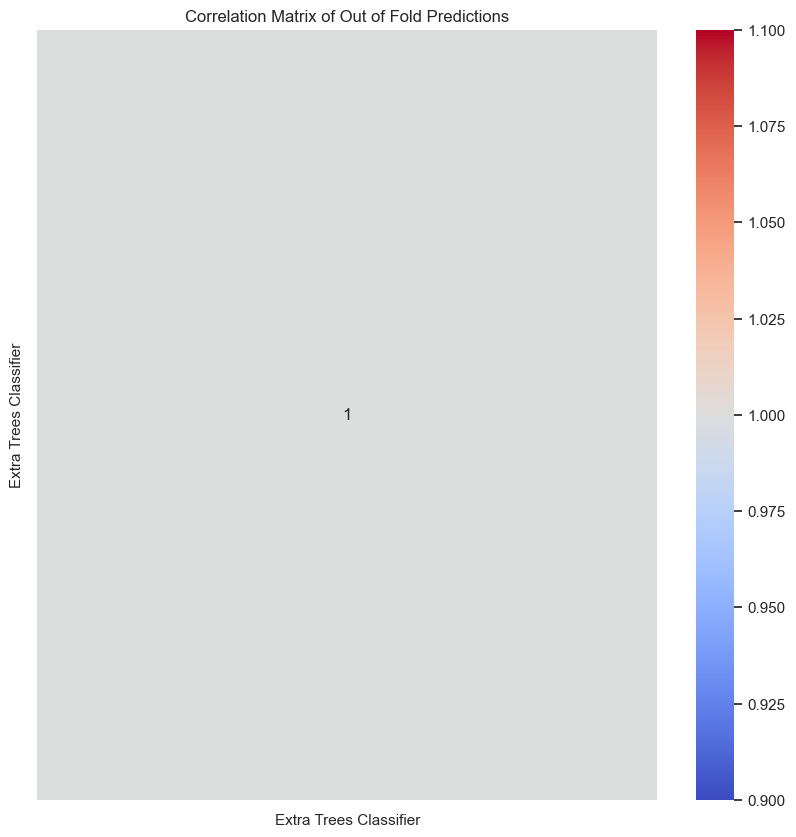

In [79]:
# plot a heatmap of the correlation matrix of the out of fold predictions
plt.figure(figsize=(10,10))
sns.heatmap(oof_predictions_df_selected.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Out of Fold Predictions')
plt.show()

In [61]:
# Display the scores
pd.DataFrame(list(zip(model_list_training, MCC_train_list_training, MCC_val_list_training)), columns=['Model Name', 'MCC_Score_Train', 'MCC_Score_val']).sort_values(by=["MCC_Score_val"],ascending=True)

,Model Name,MCC_Score_Train,MCC_Score_val
0,Extra Trees Classifier,0.974288,0.974178


In [74]:
# Use the trained models to make predictions on the test dataset

# Make predictions on the test dataset
test_predictions_df_selected = pd.DataFrame()
for i,key in enumerate (list(classifiers_selected.keys())):
    test_predictions_df_selected[list(classifiers_selected.keys())[i]] = classifiers_selected[key].predict(X1)

## 7. Meta-model via MLPRegressor

In [75]:
## Train a meta model with the OOF predictions
# Define a MLP Classifier for the meta model
meta_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='tanh', solver='adam', alpha=0.0001, learning_rate='adaptive', random_state=SEED)

# Implement a randomized search for the meta-model
# Implement a randomized search for the meta-model
params_meta = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': stats.loguniform(1e-5, 1e-2),
    'learning_rate': ['constant', 'adaptive']
}

# Setup the RandomizedSearchCV
RS_meta = RandomizedSearchCV(meta_model, params_meta, n_iter=10, cv=kf, scoring=make_scorer(MCC, greater_is_better=False),refit=True, n_jobs=-1, verbose=1)

# Fit the RandomizedSearchCV
RS_meta.fit(oof_predictions_df_selected, y_train) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MLPClassifier(activation='tanh',
                                           hidden_layer_sizes=(50, 50, 50),
                                           learning_rate='adaptive',
                                           random_state=42),
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020910D55150>,
                                        'hidden_layer_sizes': [(50, 50, 50),
                                                               (50, 100, 50),
                                                               (100,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['sgd', 'adam']},
                   scoring=make_scorer(MCC, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [76]:
# Produce the final predictions from the meta-model
y_val_meta = RS_meta.predict(val_predictions_df_selected)
# Evaluate the meta-model
MCC_meta = MCC(y_val, y_val_meta)
print(f'The MCC score of the meta-model is: {MCC_meta}')

The MCC score of the meta-model is: 0.9741776846479555


In [77]:
# Obtain the best parameters of the meta-model
best_meta_model = RS_meta.best_estimator_
# Save the best meta-model

dump(best_meta_model, "/kaggle/working/meta_model.joblib" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else "Output/meta_model.joblib", protocol=5)

# Make predictions on the test dataset
# load the meta model
meta_model = load("/kaggle/working/meta_model.joblib" if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else "Output/meta_model.joblib")
# Make predictions on the test dataset
test_predictions_meta = meta_model.predict(test_predictions_df_selected)

# Map predictions back to original labels
test_pred_class = le.inverse_transform(test_predictions_meta)

# Save the predictions in a csv file

submission_df = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv' if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else 'Input/sample_submission.csv')

submission_df['class'] = test_pred_class
submission_df.to_csv('/kaggle/working/submission.csv' if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ else 'Output/submission.csv', index=False)


## 9. Future Improvements

1. Create additional features using AutoML
2. Conduct Exploratory Data analysis on the data
    -  Explore the possiblity to better imputing the missing values by correlating with other features.
3. Use lazypredict for selecting models
    https://github.com/shankarpandala/lazypredict 